The goal of this mini-project is to practice what you have learned at each stage of the pipeline throughout the time series module. You will use the earth surface temperature data offered by Berkeley Earth through Kaggle.com. You will select one location, could be a city or a state or something relatively similar in size and analyze the patterns in temperature over time. You will then model those patterns to forecast temperature into the future (how far is up to you, but should be something meaningful).

#### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

from pandas.plotting import register_matplotlib_converters
from datetime import datetime
from sklearn.metrics import mean_squared_error, explained_variance_score
from math import sqrt

from datetime import timedelta, datetime
import requests

import env

import warnings
warnings.filterwarnings('ignore')

#### Read in the csv downloaded from Kaggle

In [2]:
df = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')

In [3]:
df.shape

(239177, 7)

In [4]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


#### Checking out what cities are available

In [5]:
df.City.unique()

array(['Abidjan', 'Addis Abeba', 'Ahmadabad', 'Aleppo', 'Alexandria',
       'Ankara', 'Baghdad', 'Bangalore', 'Bangkok', 'Belo Horizonte',
       'Berlin', 'Bogotá', 'Bombay', 'Brasília', 'Cairo', 'Calcutta',
       'Cali', 'Cape Town', 'Casablanca', 'Changchun', 'Chengdu',
       'Chicago', 'Chongqing', 'Dakar', 'Dalian', 'Dar Es Salaam',
       'Delhi', 'Dhaka', 'Durban', 'Faisalabad', 'Fortaleza', 'Gizeh',
       'Guangzhou', 'Harare', 'Harbin', 'Ho Chi Minh City', 'Hyderabad',
       'Ibadan', 'Istanbul', 'Izmir', 'Jaipur', 'Jakarta', 'Jiddah',
       'Jinan', 'Kabul', 'Kano', 'Kanpur', 'Karachi', 'Kiev', 'Kinshasa',
       'Lagos', 'Lahore', 'Lakhnau', 'Lima', 'London', 'Los Angeles',
       'Luanda', 'Madras', 'Madrid', 'Manila', 'Mashhad', 'Melbourne',
       'Mexico', 'Mogadishu', 'Montreal', 'Moscow', 'Nagoya', 'Nagpur',
       'Nairobi', 'Nanjing', 'New Delhi', 'New York', 'Paris', 'Peking',
       'Pune', 'Rangoon', 'Rio De Janeiro', 'Riyadh', 'Rome', 'São Paulo',
       'S

### Let's use Chengdu, China!
Chengdu is my furthest home away from home! A dear friend of mine lives there and I've made so many great memories and had some wonderful experiences during my time there. The latitude is also really close to San Antonio (technically closer to Austin's latitude), so that should be interesting.

In [6]:
df = df[df.City == 'Chengdu']

In [7]:
df.shape

(2318, 7)

In [8]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
49356,1820-08-01,17.288,2.018,Chengdu,China,31.35N,103.66E
49357,1820-09-01,15.097,1.650,Chengdu,China,31.35N,103.66E
49358,1820-10-01,9.458,1.525,Chengdu,China,31.35N,103.66E
49359,1820-11-01,4.292,1.557,Chengdu,China,31.35N,103.66E
49360,1820-12-01,-0.441,1.709,Chengdu,China,31.35N,103.66E


In [9]:
# Saving the csv to my computer in case I want to do some Tableau visualizations
df.to_csv('Chengdu_temps.csv')

In [10]:
# NOTE: the AverageTemperature is in celsius 
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
49356,1820-08-01,17.288,2.018,Chengdu,China,31.35N,103.66E
49357,1820-09-01,15.097,1.650,Chengdu,China,31.35N,103.66E
49358,1820-10-01,9.458,1.525,Chengdu,China,31.35N,103.66E
49359,1820-11-01,4.292,1.557,Chengdu,China,31.35N,103.66E
49360,1820-12-01,-0.441,1.709,Chengdu,China,31.35N,103.66E


In [11]:
# Checking for Nulls
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
print(rows_with_NaN)

               dt  AverageTemperature  AverageTemperatureUncertainty     City  \
49396  1823-12-01                 NaN                            NaN  Chengdu   
49397  1824-01-01                 NaN                            NaN  Chengdu   
49398  1824-02-01                 NaN                            NaN  Chengdu   
49399  1824-03-01                 NaN                            NaN  Chengdu   
49400  1824-04-01                 NaN                            NaN  Chengdu   
...           ...                 ...                            ...      ...   
49586  1839-10-01                 NaN                            NaN  Chengdu   
49587  1839-11-01                 NaN                            NaN  Chengdu   
49588  1839-12-01                 NaN                            NaN  Chengdu   
49919  1867-07-01                 NaN                            NaN  Chengdu   
51673  2013-09-01                 NaN                            NaN  Chengdu   

      Country Latitude Long

In [12]:
# only 135
df.dropna(inplace=True)

In [13]:
# Need to reformat ['dt']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2183 entries, 49356 to 51672
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             2183 non-null   object 
 1   AverageTemperature             2183 non-null   float64
 2   AverageTemperatureUncertainty  2183 non-null   float64
 3   City                           2183 non-null   object 
 4   Country                        2183 non-null   object 
 5   Latitude                       2183 non-null   object 
 6   Longitude                      2183 non-null   object 
dtypes: float64(2), object(5)
memory usage: 136.4+ KB


In [14]:
# 'dt' to datetime
df = df.assign(ds = pd.to_datetime(df.dt))

In [15]:
# sort values by date
df = df.sort_values('ds')

In [16]:
df = df.groupby(['ds'])[['AverageTemperature']].mean()

In [17]:
df.head()

,AverageTemperature
ds,
1820-08-01,17.288
1820-09-01,15.097
1820-10-01,9.458
1820-11-01,4.292
1820-12-01,-0.441


In [18]:
# Resample to quarter for seasonality
q_df = df.resample('Q').mean()

In [19]:
q_df.head()

,AverageTemperature
ds,
1820-09-30,16.192500
1820-12-31,4.436333
1821-03-31,3.860333
1821-06-30,14.434333
1821-09-30,17.045333


In [20]:
q_df.shape

(773, 1)

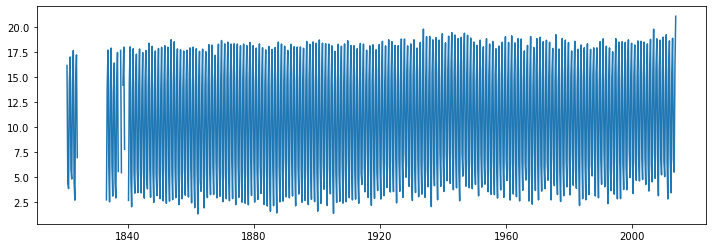

In [21]:
# This looks weird...
plt.figure(figsize=(12,4))
plt.plot(q_df.AverageTemperature)
plt.show()

Let's check it out in Tableau

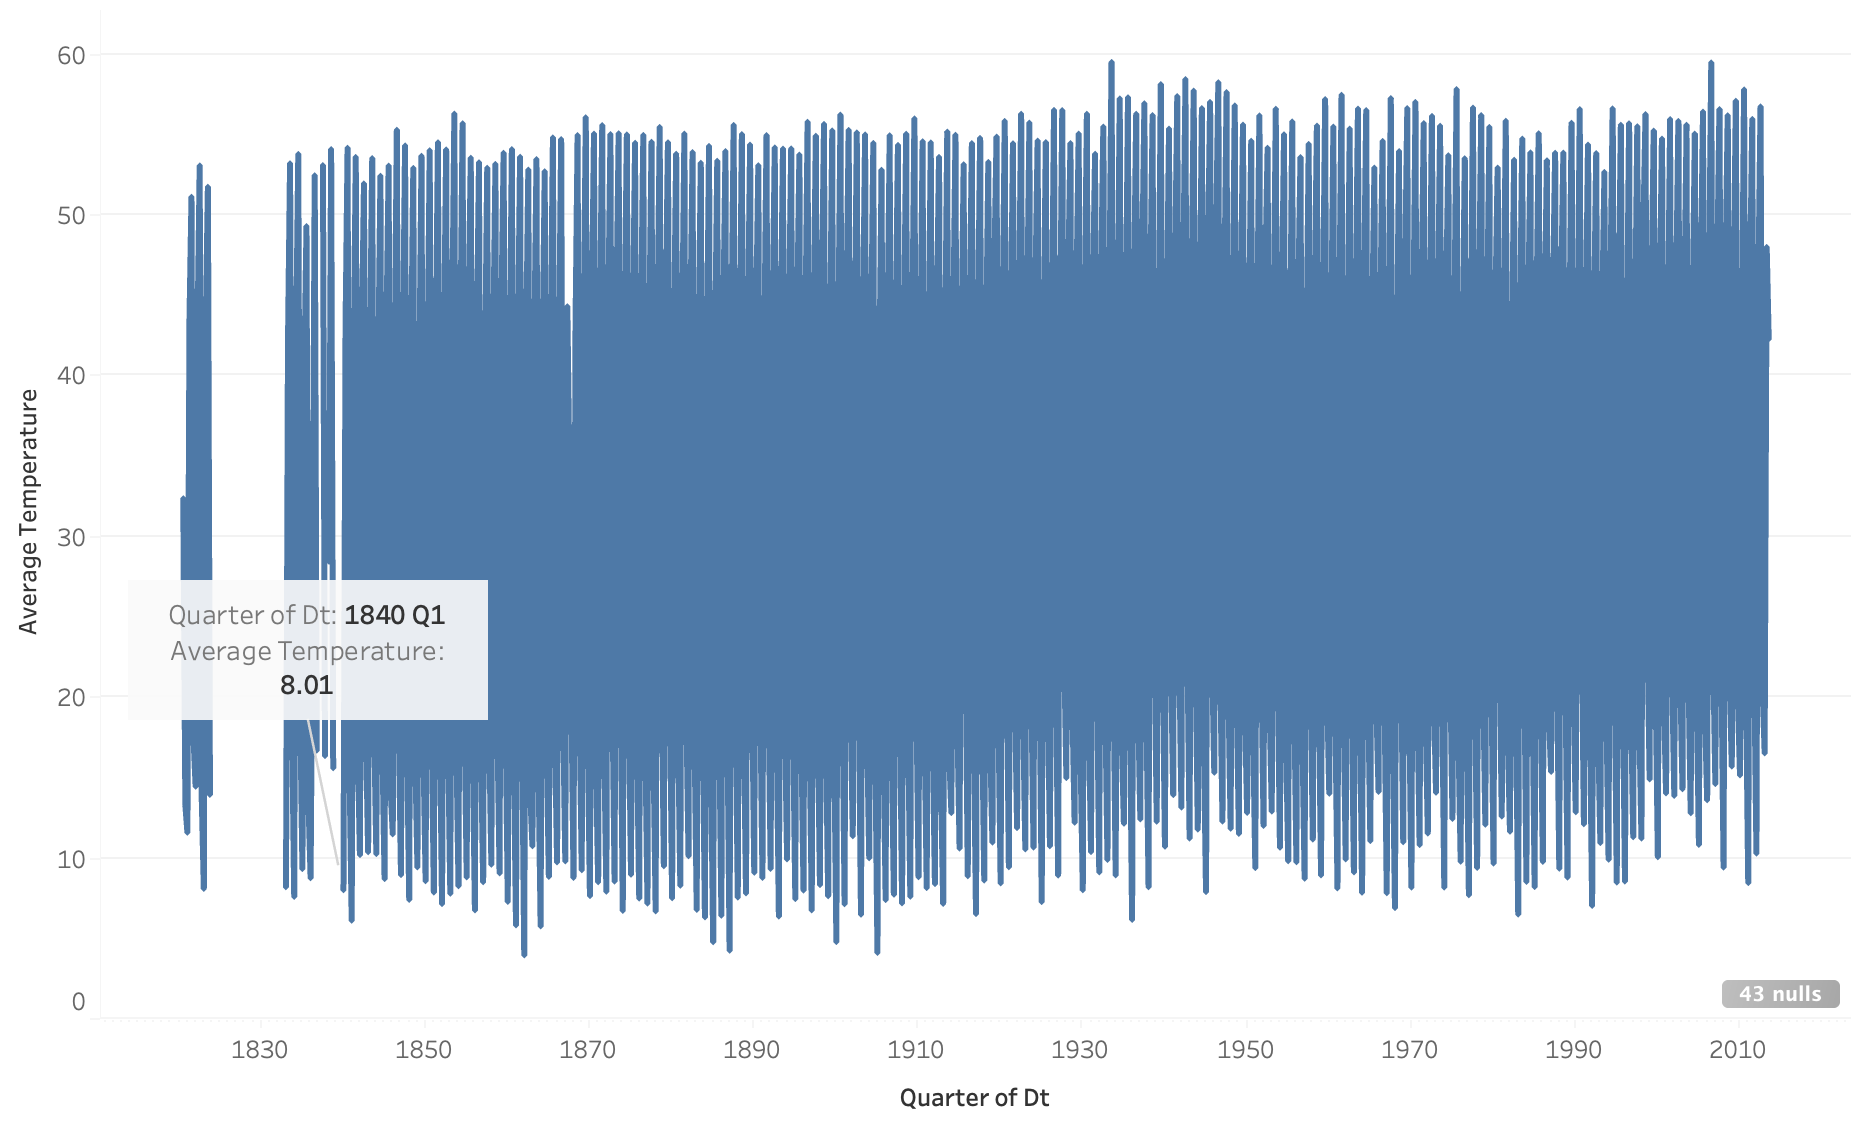

Looks like we'll want to use our data from 1840 on

In [22]:
q_df = q_df.loc['1840':]
q_df

,AverageTemperature
ds,
1840-03-31,2.668333
1840-06-30,14.307000
1840-09-30,18.061667
1840-12-31,4.957333
1841-03-31,2.033000
...,...
2012-09-30,18.920000
2012-12-31,6.846000
2013-03-31,5.504000


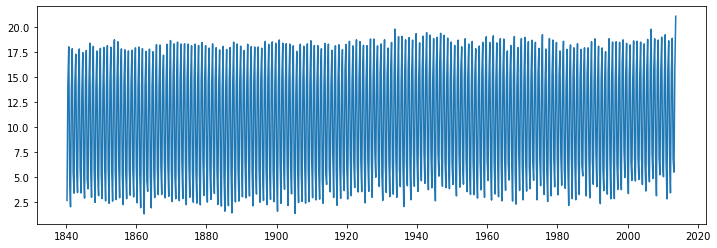

In [23]:
plt.figure(figsize=(12,4))
plt.plot(q_df.AverageTemperature)

Better

#### Split Data

Splitting my data by a clean year cutoff

In [24]:
train_size = int(len(q_df) * .5)
validate_size = int(len(q_df) * .3)
test_size = int(len(q_df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = q_df[: train_size]
validate = q_df[train_size : validate_end_index]
test = q_df[validate_end_index : ]

In [25]:
train

,AverageTemperature
ds,
1840-03-31,2.668333
1840-06-30,14.307000
1840-09-30,18.061667
1840-12-31,4.957333
1841-03-31,2.033000
...,...
1925-09-30,18.178000
1925-12-31,6.642000
1926-03-31,3.578333


In [26]:
validate

,AverageTemperature
ds,
1926-12-31,6.816667
1927-03-31,2.973333
1927-06-30,14.469333
1927-09-30,18.842000
1927-12-31,7.458667
...,...
1977-09-30,18.893000
1977-12-31,6.501667
1978-03-31,3.132667


In [27]:
test

,AverageTemperature
ds,
1978-12-31,6.811667
1979-03-31,4.025333
1979-06-30,15.007000
1979-09-30,18.493667
1979-12-31,6.808000
...,...
2012-09-30,18.920000
2012-12-31,6.846000
2013-03-31,5.504000


In [28]:
# So to get a full year in each split:
train = q_df.loc[:'1926']
validate = q_df.loc['1927':'1979']
test = q_df.loc['1980':]

In [29]:
train

,AverageTemperature
ds,
1840-03-31,2.668333
1840-06-30,14.307000
1840-09-30,18.061667
1840-12-31,4.957333
1841-03-31,2.033000
...,...
1925-12-31,6.642000
1926-03-31,3.578333
1926-06-30,14.597333


In [30]:
def plot_samples(target_var):
    '''
    this function will plot the train, validate and test values for a 
    single variable across all dateas.
    '''
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var])
    plt.plot(validate[target_var])
    plt.plot(test[target_var])
    plt.title(target_var)
    plt.show()

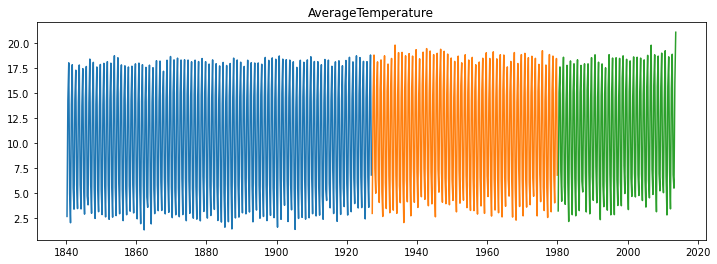

In [31]:
plot_samples('AverageTemperature')

Before we try out different methods for forecasting temperatures, let's create a couple of functions that will be helpful in evaluating each of the methods that follow. 

`evaluate()` will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.  

In [32]:
# define evaluation function to compute rmse

def evaluate(target_var):
    '''
    the evaluate function will take in the actual value in validate 
    and the predicted values
    and compute the mean_squared_error and then take the square root
    and round to 0 decimals.
    It will return the rmse, an integer.
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])),2)
    return rmse

`plot_and_eval()` will use the evaluate function and also plot train and test values with the predicted values in order to compare performance. 


In [33]:
# plot and evaluate: plot
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

Write `append_eval_df(model_type)` to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our `eval_df` data frame object. Which we will create an empty `eval_df` dataframe object to start. 

In [34]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns = ['model_type','target_var','rmse'])

In [35]:
# check out the data frame
eval_df

,model_type,target_var,rmse


In [36]:
# Define function to store rmse for comparison purposes

def append_eval_df(model_type, target_var):
    '''
    this function is going to take in the model_type as a string, the target variable as a string,
    and run the evaluate() function to compute the rmse,
    and append to the data frame a row with the model_type, target_var, and rmse.
    It will return the new dataframe.
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)

## Forecast 

- Last observed value
- Simple average
- Moving average
- Holt's Linear Trend
- Previous cycle

### Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

**Make Predictions**

In [37]:
# create var 'temps' with last observed value ....
# this may not be all that useful since I'm doing by quarter, but let's see! MVP
temps = train['AverageTemperature'][-1]
temps

6.816666666666666

In [38]:
# make predictions by adding this values to new dataframe yhat_df
yhat_df = pd.DataFrame({'AverageTemperature': [temps]}, index = validate.index)

yhat_df.head(2)

,AverageTemperature
ds,
1927-03-31,6.816667
1927-06-30,6.816667


You can see, when peeking into yhat_df, that every predicted value is the same.  

**Plot Actual vs. Predicted Values**

Now, let's plot actual and predicted values

AverageTemperature -- RMSE: 7


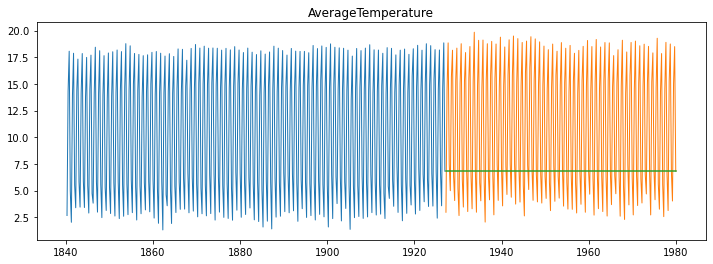

In [39]:
plot_and_eval('AverageTemperature')

**Evaluate** 

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [40]:
eval_df = append_eval_df(model_type = 'last_observed_value', target_var = 'AverageTemperature')

In [41]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,7.43


### Simple Average

Take the simple average of historical values and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 

**Make Predictions**

In [42]:
temps = round(train['AverageTemperature'].mean(),2)

def make_predictions(temps):
    yhat_df = pd.DataFrame({'AverageTemperature': [temps]}, index = validate.index)
    return yhat_df

In [43]:
yhat_df = make_predictions(temps)
yhat_df

,AverageTemperature
ds,
1927-03-31,10.32
1927-06-30,10.32
1927-09-30,10.32
1927-12-31,10.32
1928-03-31,10.32
...,...
1978-12-31,10.32
1979-03-31,10.32
1979-06-30,10.32


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Simple Average**

AverageTemperature -- RMSE: 6


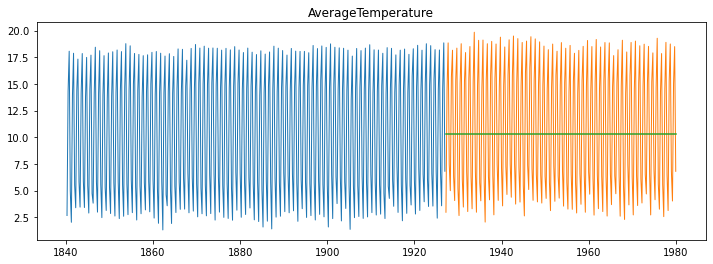

In [44]:
plot_and_eval('AverageTemperature')

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [45]:
eval_df = append_eval_df(model_type = 'simple_average', target_var = 'AverageTemperature')

In [46]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,7.43
1,simple_average,AverageTemperature,6.21


### Moving Average

In this example, we will use a 4 quarter (1 year) moving average to forecast. In other words, the average over the last year will be used as the forecasted value. 

**Make Predictions**

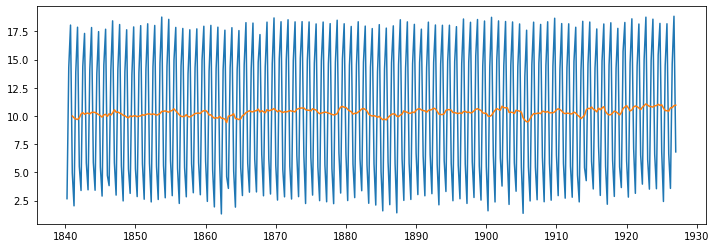

In [47]:
plt.figure(figsize=(12,4))
plt.plot(train['AverageTemperature'])
plt.plot(train['AverageTemperature'].rolling(4).mean())

In [48]:
period = 4
# use the rolling method, take the mean of the last 30 days, and select the last value,
# i.e. the last day in train. round to 2 decimals
# do that for each target var
temps = round(train['AverageTemperature'].rolling(period).mean().iloc[-1],0)

print(temps)

11.0


In [49]:
# create a new yhat data frame with the forecast through validate dates.

yhat_df = make_predictions(temps)
yhat_df.head(3)

,AverageTemperature
ds,
1927-03-31,11.0
1927-06-30,11.0
1927-09-30,11.0


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Moving Average**

AverageTemperature -- RMSE: 6


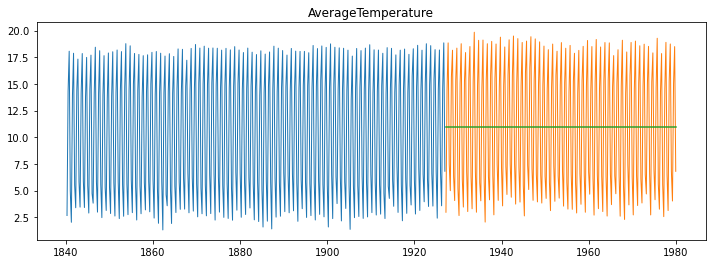

In [50]:
plot_and_eval('AverageTemperature')

**Evaluate**

Evaluate using RMSE, and add evaluation metrics to `eval_df`

In [51]:
eval_df = append_eval_df(model_type = '1 year moving average', target_var = 'AverageTemperature')

In [52]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,7.43
1,simple_average,AverageTemperature,6.21
2,1 year moving average,AverageTemperature,6.18


### Holt's Linear Trend

Exponential smoothing applied to both the average and the trend (slope).  

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 


**Seasonal Decomposition**

First, let's take a look at the seasonal decomposition for each target. 

In [53]:
train.head()

,AverageTemperature
ds,
1840-03-31,2.668333
1840-06-30,14.307000
1840-09-30,18.061667
1840-12-31,4.957333
1841-03-31,2.033000


In [54]:
#import statsmodels.api as sm

#for col in train.columns:
    #print(col, '\n')
    #_ = sm.tsa.seasonal_decompose(train[col].resample('m').mean()).plot()
    #plt.show()

#### Basic Holt's Linear Trend

**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions. 

Holt: 

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)

fit: 

- smoothing_level ($\alpha$): value between (0,1)
- smoothing_slope ($\beta$): value between (0,1)

In [55]:
for col in train.columns:
    # creating the holt object
    model = Holt(train['AverageTemperature'], exponential = False)
    # fit the model providing the alpha/smoothing level and beta/smoothing slope
    model = model.fit(smoothing_level = .0366, 
                      smoothing_slope = .0366,
                      optimized = False)

    # predict/forecast providing the start and end dates
    yhat_items = model.predict(start = validate.index[0], end = validate.index[-1])

    yhat_df[col] = round(yhat_items, 2)

**Plot Actual vs. Predicted Values**

AverageTemperature -- RMSE: 6


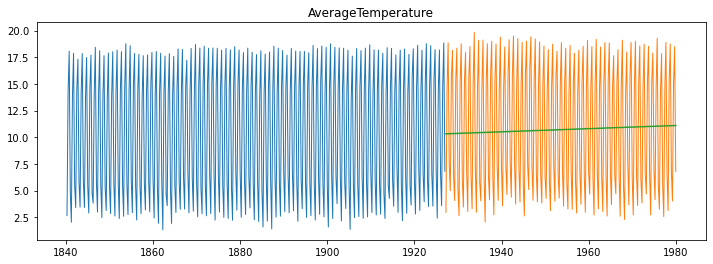

In [56]:
for col in train.columns:
    eval_df = append_eval_df(model_type='Holts', target_var = col)
    plot_and_eval(target_var = col)

**Evaluate**

In [57]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,7.43
1,simple_average,AverageTemperature,6.21
2,1 year moving average,AverageTemperature,6.18
3,Holts,AverageTemperature,6.19


#### Let's use our 1 year moving average on test

In [58]:
period = 4
# use the rolling method, take the mean of the last 30 days, and select the last value,
# i.e. the last day in train. round to 2 decimals
# do that for each target var
temps = round(test['AverageTemperature'].rolling(period).mean().iloc[-1],0)

print(temps)

12.0


In [59]:
def make_predictions(temps):
    yhat_df = pd.DataFrame({'AverageTemperature': [temps]}, index = test.index)
    return yhat_df

In [60]:
# create a new yhat data frame with the forecast through test dates.

yhat_df = make_predictions(temps)
yhat_df.head(3)

,AverageTemperature
ds,
1980-03-31,12.0
1980-06-30,12.0
1980-09-30,12.0


In [61]:
def evaluate(target_var):
    '''
    the evaluate function will take in the actual value in validate 
    and the predicted values
    and compute the mean_squared_error and then take the square root
    and round to 0 decimals.
    It will return the rmse, an integer.
    '''
    rmse = round(sqrt(mean_squared_error(test[target_var], yhat_df[target_var])),2)
    return rmse

In [62]:
evaluate('AverageTemperature')

6.13

In [63]:
eval_df = append_eval_df(model_type = '1 year moving average Test', target_var = 'AverageTemperature')
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,7.43
1,simple_average,AverageTemperature,6.21
2,1 year moving average,AverageTemperature,6.18
3,Holts,AverageTemperature,6.19
4,1 year moving average Test,AverageTemperature,6.13


### Plotting the future!

In [65]:
future = test.copy() # create future predictions dataframe

In [66]:
future.index = future.index + pd.Timedelta('20Y') # add 20 years to test split's dates

In [67]:
future

,AverageTemperature
ds,
2000-03-30 20:24:00,3.221333
2000-06-29 20:24:00,15.092000
2000-09-29 20:24:00,17.650000
2000-12-30 20:24:00,7.233333
2001-03-30 20:24:00,4.192000
...,...
2032-09-29 20:24:00,18.920000
2032-12-30 20:24:00,6.846000
2033-03-30 20:24:00,5.504000


<AxesSubplot:xlabel='ds'>

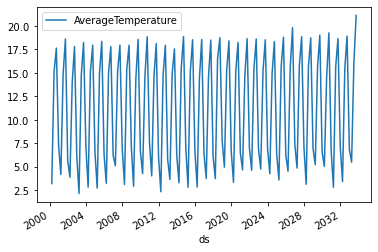

In [68]:
future.plot()

In [69]:
future = future.loc['2013-12-30':]

In [70]:
future

,AverageTemperature
ds,
2013-12-30 20:24:00,6.238000
2014-03-30 20:24:00,3.299333
2014-06-29 20:24:00,15.528333
2014-09-29 20:24:00,18.876667
2014-12-30 20:24:00,6.943333
...,...
2032-09-29 20:24:00,18.920000
2032-12-30 20:24:00,6.846000
2033-03-30 20:24:00,5.504000


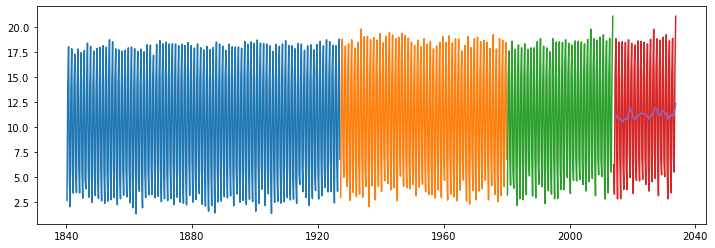

In [72]:
plt.figure(figsize=(12,4))
plt.plot(train['AverageTemperature'])
plt.plot(validate['AverageTemperature'])
plt.plot(test['AverageTemperature'])
plt.plot(future)
plt.plot(future['AverageTemperature'].rolling(4).mean())